In [1]:
%load_ext autoreload
%autoreload 2

# Monte Carlo Explorations

We will conduct some basic Monte Carlo explorations with the **grmpy** package. This allows us to revisit the key message of the course.

In [2]:
import pickle as pkl
import numpy as np
import copy 

from statsmodels.sandbox.regression.gmm import IV2SLS
from mc_exploration_functions import *
import statsmodels.api as sm
import seaborn.apionly as sns

import grmpy

/home/peisenha/.envs/policyMetrics/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/peisenha/.envs/policyMetrics/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
model_base = get_model_dict('mc_exploration.grmpy.ini')
model_base['SIMULATION']['source'] = 'mc_data'

df_base = grmpy.simulate('mc_exploration.grmpy.ini')
df_base.head()

,Y,D,X_0,Z_0,Z_1,Y1,Y0,U1,U0,UC,V
0,1.536747,0,1.0,1.0,-0.388416,2.052736,1.536747,0.052736,0.036747,0.426368,0.410380
1,2.167313,1,1.0,1.0,-1.101463,2.167313,1.584724,0.167313,0.084724,-1.706945,-1.789534
2,2.077226,1,1.0,1.0,0.317234,2.077226,1.509501,0.077226,0.009501,-1.352652,-1.420377
3,1.986588,1,1.0,1.0,-1.014587,1.986588,1.474809,-0.013412,-0.025191,0.064590,0.052811
4,1.221890,0,1.0,1.0,1.896017,2.053207,1.221890,0.053207,-0.278110,0.287561,-0.043756


### Questions

* What are the remaining sources of heterogeneity?
* What is the average treatment effect? Do you expect any to the other conventional treatment effect parameters?
* What does this imply for the marginal benefit of treatment?

In [4]:
d_treated = (df_base['D'] == 1)

ate = np.mean(df_base['Y1'] - df_base['Y0'])
tt = np.mean(df_base['Y1'].loc[d_treated] - df_base['Y0'].loc[d_treated])
tut = np.mean(df_base['Y1'].loc[~d_treated] - df_base['Y0'].loc[~d_treated])

true_effect = ate

print('Effect ', ate, tt, tut)

Effect  0.5004160612534729 0.4986615641592484 0.5015591646451684


However, we still have a considerable amount of treatment effect heterogeneity.

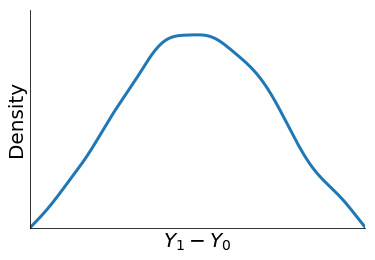

In [5]:
plot_distribution_of_benefits(df_base)

Now let us get ready to explore the effects of essential heterogeneity with some auxiliary functions.

In [6]:
def update_correlation_structure(model_dict, rho):
    """This function takes a valid model specification and updates the correlation structure
    among the unobservables."""
    # We first extract the baseline information from the model dictionary.
    sd_v = model_dict['DIST']['all'][-1]
    sd_u =  model_dict['DIST']['all'][0]
    
    # Now we construct the implied covariance, which is relevant for the initialization file.
    cov = rho * sd_v * sd_u
    model_dict['DIST']['all'][2] = cov
    
    # We print out the specification to an initialization file with the name mc_init.grmpy.ini.
    print_model_dict(model_dict)
    
def collect_effects(model_base, which, grid_points):
    """This function collects numerous effects for alternative correlation structures."""
    model_mc = copy.deepcopy(model_base)
    
    effects = []
    for rho in np.linspace(0.00, 0.99, grid_points):
        
        # We create a new initialization file with an  updated correlation structure.
        update_correlation_structure(model_mc, rho)
    
        # We use this new file to simulate a new sample.
        df_mc = grmpy.simulate('mc_init.grmpy.ini')
        
        # We extract auxiliary objects for further processing.
        endog, exog, instr = df_mc['Y'], df_mc[['X_0', 'D']], df_mc[['X_0', 'Z_1']]
        d_treated = df_mc['D'] == 1
                                                                    
        # We calculate our parameter of interest.
        label = which.lower()
        if label == 'randomization':
            stat = np.mean(endog.loc[d_treated]) - np.mean(endog.loc[~d_treated])
        elif label == 'ordinary_least_squares':
            stat = sm.OLS(endog, exog).fit().params[1]
        elif label == 'conventional_instrumental_variables': 
            stat = IV2SLS(endog, exog, instr).fit().params[1]
        elif label == 'local_instrumental_variables':
            grmpy.estimate('mc_init.grmpy.ini')
            stat = get_effect_grmpy()
        elif label == 'conventional_average_effects':
            ate = np.mean(df_mc['Y1'] - df_mc['Y0'])
            tt = np.mean(df_mc['Y1'].loc[d_treated] - df_mc['Y0'].loc[d_treated])
            stat = (ate, tt)
        else:
            raise NotImplementedError
        
        effects += [stat]
    
    return effects

How doe he different treatment effect parameters diverge if we introduce essential heterogeneity?

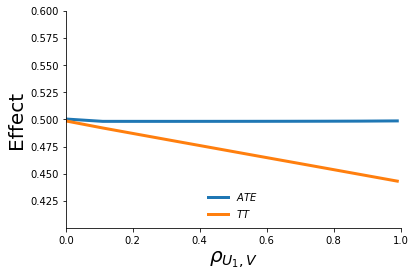

In [7]:
effects = collect_effects(model_base, 'conventional_average_effects', 10)
plot_effects(effects)

Let us investigate the essential heterogentiy with respect to the distribution of the unobservables.

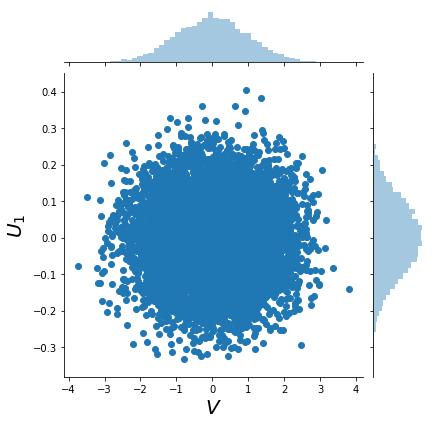

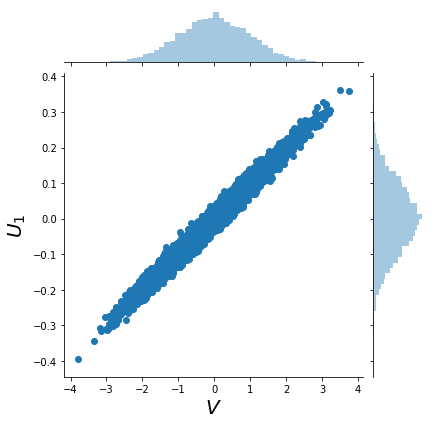

In [8]:
df_mc = pkl.load(open('mc_data.grmpy.pkl', 'rb'))
for df in [df_base, df_mc]:
    plot_joint_distribution_unobservables(df)

Let us revisit the shape of the marginal benefit of treatment with and without essential hetergeneity.

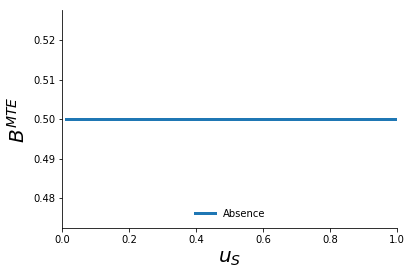

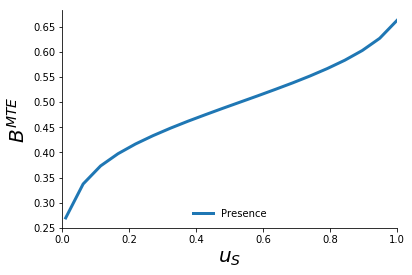

In [9]:
for fname in ['data', 'mc_data']:
    plot_marginal_effect(get_marginal_effect_grmpy(fname + '.grmpy.info'))

### Estimation Strategies

* Randomization
* Ordinary Least Squares
* Instrumental Variables
    * Conventional
    * Local


## Randomization

We start with the baseline model.

In [10]:
effect = np.mean(df_base['Y'].loc[d_treated]) - np.mean(df_base['Y'].loc[~d_treated])
print('Effect ', effect)

Effect  0.49910136621884327


Now we can directly look at the effect of essential heterogeneity.

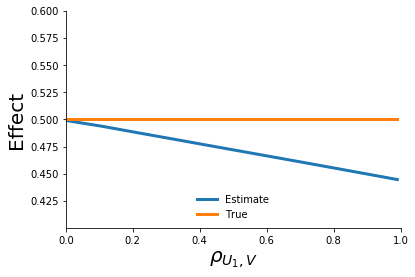

In [11]:
effects = collect_effects(model_base, 'randomization', 10)
plot_estimates(true_effect, effects)

## Ordinary Least Squares

We first look at a regression in the baseline sample in more detail.

In [12]:
results = sm.OLS(df_base['Y'], df_base[['X_0', 'D']]).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                 6.044e+04
Date:                Thu, 25 Jan 2018   Prob (F-statistic):               0.00
Time:                        09:16:01   Log-Likelihood:                 8915.7
No. Observations:               10000   AIC:                        -1.783e+04
Df Residuals:                    9998   BIC:                        -1.781e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X_0            1.4988      0.001   1175.397      0.000       1.496       1.501
D              0.4991      0.002    245.848      0.000       0.495       0.503
==============================================================================
Omnibus:                        0.533   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.766   Jarque-Bera (JB):                0.514
Skew:                          -0.016   Prob(JB):                        0.773
Kurtosis:                       3.012   Cond. No.                         2.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we again investigate the effect of essential heterogeneity on our estimates.

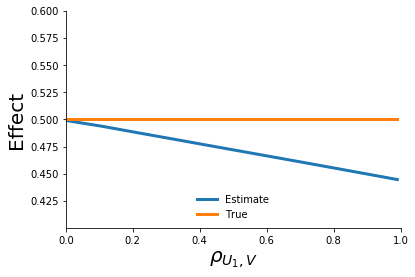

In [13]:
effects = collect_effects(model_base, 'ordinary_least_squares', 10)
plot_estimates(true_effect, effects)

## Coventional Instrumental Variables Regression

In [14]:
result = IV2SLS(df_base['Y'], df_base[['X_0', 'D']], df_base[['X_0', 'Z_1']]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.858
Model:                         IV2SLS   Adj. R-squared:                  0.858
Method:                     Two Stage   F-statistic:                 2.562e+04
                        Least Squares   Prob (F-statistic):               0.00
Date:                Thu, 25 Jan 2018                                         
Time:                        09:16:19                                         
No. Observations:               10000                                         
Df Residuals:                    9998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X_0            1.5001      0.002    953.062      0.000       1.497       1.503
D              0.4957      0.003    160.072      0.000       0.490       0.502
==============================================================================
Omnibus:                        0.474   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.455
Skew:                          -0.015   Prob(JB):                        0.797
Kurtosis:                       3.012   Cond. No.                         2.44
==============================================================================
"""

Now we introduce essential heterogeneity.

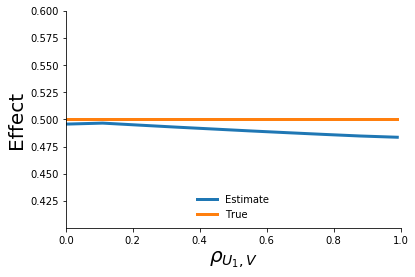

In [15]:
effects = collect_effects(model_base, 'conventional_instrumental_variables', 10)
plot_estimates(true_effect, effects)

## Local Instrumental Variables

We look at our baseline specification first.

In [16]:
rslt = grmpy.estimate('mc_exploration.grmpy.ini')
print('Effect ', get_effect_grmpy())

Effect  0.4987


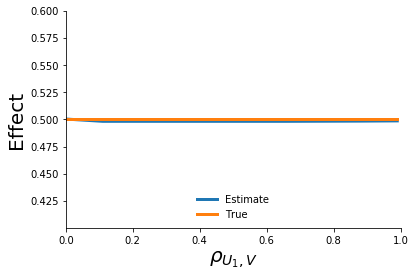

In [17]:
effects = collect_effects(model_base, 'local_instrumental_variables', 10)
plot_estimates(true_effect, effects)

## Other Objects of Interest

Let us conclude by revisiting some additional objects of interest such as the joint distribution of potential outcomes and benefits and surplus. All of these can be obtained when, for example, the requirements for a factor structure approach as in Carneiro (2003) are met. 

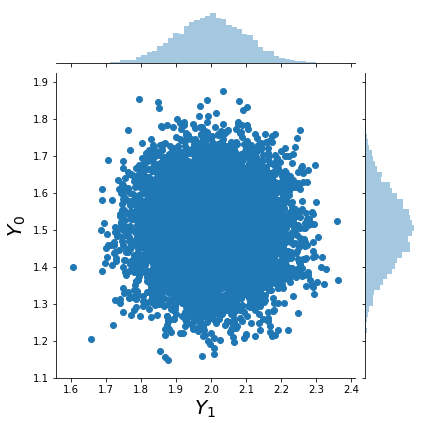

In [18]:
plot_joint_distribution_potential(df)

Now we turn to the joint distribution of benefits and costs. What is the meaning of each quadrant?

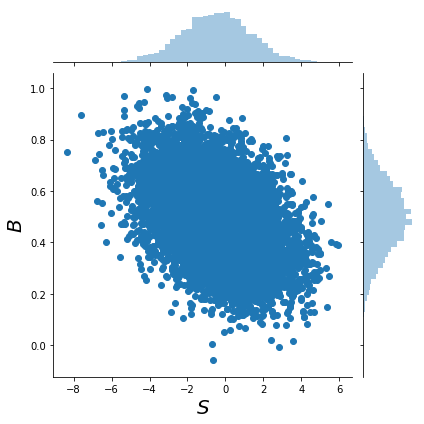

In [19]:
plot_joint_distribution_benefits_surplus(model_base, df)